In [28]:
import xgboost as xgb
import pandas as pd
import os
import math
from tqdm import tqdm
from gensim import corpora
from collections import defaultdict
from gensim import models

import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import plotly.express as px
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import pickle

from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk

#nltk.download('stopwords')
#nltk.download('vader_lexicon')

from nltk.corpus import stopwords
stop_set = set(stopwords.words('english'))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jimni\AppData\Roaming\nltk_data...


In [23]:
def create_texts(article):
    texts = [ [word for word in document.lower().split() if word not in stop_set] for document in article]


    frequency = defaultdict(int)

    for text in texts:
        for token in text:
            frequency[token] += 1

    #texts = [ [token for token in text if frequency[token] > 1] for text in texts]





    return texts

In [24]:
def compute_coherence(dictionary, corpus, texts, cohere_vers, chunksize,
                      limit, start, step):
## Iterates through all the number of topics defined by start and stop and creating LDA models to calculate the coherence
    coherence_vals = []
    
    for i in tqdm (range(start,limit,step)):
        num_topics = i
        lda_model = models.ldamodel.LdaModel(corpus, 
                                             id2word=dictionary, 
                                             num_topics=num_topics,
                                             chunksize = chunksize,
                                             iterations = iterations,
                                             passes = passes, 
                                             eval_every = eval_every,
                                             random_state = 3)
        coherencemod=models.coherencemodel.CoherenceModel(model=lda_model,
                                                          texts=texts,
                                                          dictionary=dictionary,
                                                          coherence='c_v')
        coherence_vals.append(coherencemod.get_coherence())
        #print("Num_topics:",i, "Coherence:",coherencemod.get_coherence())
    

        
    return coherence_vals

In [25]:
def cosine_simil_score(a,b):
## Function to check for duplicates and also outlier documents that are not related to other articles in the corpus
    thing = a.copy()
    thing2 = b.copy()


    ## Loops to create document matrix that are the same size ##
    if len(thing) != len(thing2):
        if len(thing) > len(thing2):
            diff = len(thing)-len(thing2)
            for i in range(0,diff):
                thing2.append((0,0))
        else:
            diff = len(thing2) - len(thing)
            for i in range(0,diff):
                thing.append((0,0))


    ## Creates word vectors to do cosine simularity on ##
    wordsA = []
    wordsB = []
    for i in thing:
        wordsA.append(i[0])
    for i in thing2:
        wordsB.append(i[0])



    ## Math on the word vectors
    dot = np.dot(wordsA,wordsB) 
    magA = np.linalg.norm(wordsA) 
    magB = np.linalg.norm(wordsB) 


    css = np.arccos(dot / (magA *magB)) * (180 / np.pi)
    return css


**Sentiment and Subjectivity Analyzer**

In [29]:

dataframe = pd.read_csv('C:\\Users\\jimni\\LocalCapstone\\tfidf_dataset.csv')
dataframe = dataframe.dropna()
#print(dataframe)

#results dicitonary is a list for the NLTK scores
results = {}

#blobRes dictionary is a list for blobText scores
blobRes = {}

#texts dictionary is a list for the conent of the articles to be cleaned
texts = {}

#heads is a dictionary for the content of the headings to be cleaned
#heads = {}
sent = SentimentIntensityAnalyzer()
#print("hi")

for i, row in tqdm(dataframe.iterrows(), total = len(dataframe)):
    #assign row variables
    text = row['article']
    Id = row['index']

    
    #normalize text (lowercase)
    text = text.lower()
    
    #for each article, take the polarity scores
    results[Id] = sent.polarity_scores(text)
    texts[Id] = text
    
    #put into a list of cleaned content for each article
    
    #obtain list of each TextBlob sentiment/subjectivity score from the blobtext variable
    blobRes[Id] = (TextBlob(text).sentiment)

100%|██████████████████████████████████████████████████████████████████████████| 2225/2225 [00:17<00:00, 130.79it/s]


In [30]:
#obtain datadrame from results list using pandas
NLTK = pd.DataFrame(results).T

#reset the dataframe index and change column name to Id
NLTK = NLTK.reset_index(drop = True)

#combine the results data witht the original csv dataframe
vaders = pd.concat([dataframe, NLTK], axis = 1, join = 'outer')

#create dataframe using list of TextBlob scores
BlobFrame = pd.DataFrame(blobRes).T

#re-lable columns for better readability
BlobFrame.columns = ['Sentiment', 'Subjectivity']

#reset blobframe index so that when concated, they line up
BlobFrame = BlobFrame.reset_index(drop = True)

#combine the updated csv (from the last line of code) to the textblob scores dataframe
vaderBlob = pd.concat([vaders, BlobFrame], axis = 1, join = 'outer')

#initialize k
k = 0

#replace the heading with cleaned heading using a loop
for i, row in tqdm(vaders.iterrows(), total = len(vaders)):
    #heading = row['headline']
    text = row['article']
    
    #set the headings to be replaced to the list of head at position k
    #headreplace = heads[k]
    textreplace = texts[k]
    
    #replace the headings and update the vaderBlob dataframe by setting it equal to the new replaced dataframe
    #vaderBlob = vaderBlob.replace(heading, headreplace)
    vaderBlob = vaderBlob.replace(text, textreplace)
    
    #move index forward 1
    k = k + 1
    
print(vaderBlob)

100%|██████████████████████████████████████████████████████████████████████████| 2225/2225 [00:03<00:00, 672.90it/s]

      index                                            article          topic  \
0         0  musicians tackle red tape musicians groups tac...  entertainment   
1         1  u2 desire number u2 won prestigious grammy awa...  entertainment   
2         2  rocker doherty stage fight rock singer pete do...  entertainment   
3         3  snicket tops box office chart film adaptation ...  entertainment   
4         4  ocean raids box office ocean crime caper seque...  entertainment   
...     ...                                                ...            ...   
2220   2220  norway upholds napster ruling norwegian studen...           tech   
2221   2221  warning windows word files writing microsoft w...           tech   
2222   2222  fast lifts record books high speed lifts world...           tech   
2223   2223  nintendo adds media playing ds nintendo releas...           tech   
2224   2224  fast moving phone viruses appear security firm...           tech   

        neg    neu    pos  

**Topic Modeling**

In [31]:
new_df = vaderBlob.copy()
print(new_df)
print(new_df.columns)

      index                                            article          topic  \
0         0  musicians tackle red tape musicians groups tac...  entertainment   
1         1  u2 desire number u2 won prestigious grammy awa...  entertainment   
2         2  rocker doherty stage fight rock singer pete do...  entertainment   
3         3  snicket tops box office chart film adaptation ...  entertainment   
4         4  ocean raids box office ocean crime caper seque...  entertainment   
...     ...                                                ...            ...   
2220   2220  norway upholds napster ruling norwegian studen...           tech   
2221   2221  warning windows word files writing microsoft w...           tech   
2222   2222  fast lifts record books high speed lifts world...           tech   
2223   2223  nintendo adds media playing ds nintendo releas...           tech   
2224   2224  fast moving phone viruses appear security firm...           tech   

        neg    neu    pos  



Corpus created... 
Now moving onto coherence evaluation



100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [03:53<00:00, 46.72s/it]

range(4, 9)


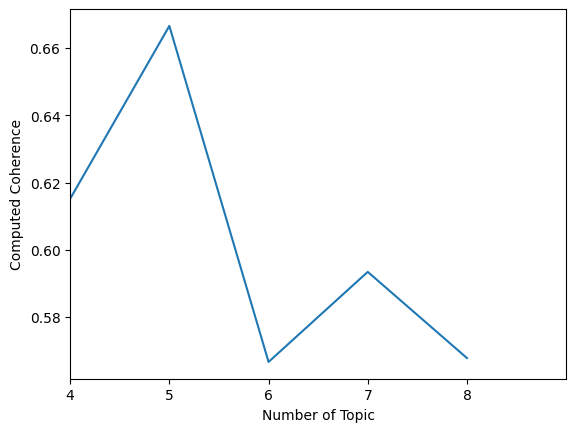

The best number of topics was 5


 Now moving on to Creating the model and topic buckets that will be sent to the xgboost model...



Coherence Score:  0.6475559186216568


Topics Found
Topic 0:
 (0, '0.009*"film" + 0.007*"best" + 0.004*"music" + 0.004*"awards" + 0.003*"award" + 0.003*"star" + 0.002*"band" + 0.002*"actor" + 0.002*"films" + 0.002*"£"') 

Topic 1:
 (1, '0.007*"people" + 0.004*"mobile" + 0.004*"technology" + 0.003*"users" + 0.003*"digital" + 0.003*"games" + 0.003*"new" + 0.003*"net" + 0.003*"software" + 0.003*"year"') 

Topic 2:
 (2, '0.016*"mr" + 0.006*"government" + 0.006*"labour" + 0.005*"election" + 0.005*"blair" + 0.004*"people" + 0.004*"party" + 0.003*"brown" + 0.003*"£" + 0.003*"minister"') 

Topic 3:
 (3, '0.005*"game" + 0.005*"england" + 0.004*"6" + 0.003*"win" + 0.003*"club" + 0.003*"world" + 0.003*"ireland" + 0.003*"play" + 0.003*"cup" + 0.003*"wales"') 

Topic 4:
 (4, '0.005*"company" + 0.004*"firm" + 0.003*"oil" + 0.003*"shares" + 0.003*"bank" + 0.003*"market

In [33]:

#copy the article column to a list so that we can run the topic model algorithms on it
article = vaderBlob['article'].to_list()

#make a list of lists with the words to be converted into wordIDs
texts = create_texts(article)

#print(texts[0])

#creating the dictionary and corpus which is what the topic model algorithm uses to find topics
dictionary  = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

print("\n\nCorpus created... \nNow moving onto coherence evaluation\n")





########################## Coherence Evaluation to determine right number of topics ##################################


### Topic Model Hyperparameters
start = 4
step = 1
limit = 9
chunksize = 750
passes = 20
iterations = 200
eval_every = 10

## module definition which iterates through all the number of topics and finds the best one
coherence_vals = compute_coherence(dictionary=dictionary,
                                  corpus=corpus,
                                  texts=texts,
                                  cohere_vers='c_v',
                                  chunksize=chunksize,
                                  start=start,
                                  limit=limit,
                                  step=step)


x = range(start,limit,step)
print(x)

############ Creates the graphical output to show which number of topics was best
plt.xlim(start,limit)
plt.xticks(range(start,limit,step))
plt.xlabel('Number of Topic')
plt.ylabel('Computed Coherence')

plt.plot(x,coherence_vals,'-')
plt.show()
#################
print('The best number of topics was', coherence_vals.index(max(coherence_vals))+start)
print('\n\n Now moving on to Creating the model and topic buckets that will be sent to the xgboost model...\n\n')


############################ Creating topic model using best number of topics ############################

NUM_topics = coherence_vals.index(max(coherence_vals)) + start
chunksize = 750
passes = 20
iterations = 200
eval_every = 10
alpha = 0.62
beta = 0.92


lda_model = models.ldamodel.LdaModel(corpus = corpus,
                                     id2word=dictionary,
                                     num_topics=NUM_topics,
                                     chunksize = chunksize,
                                     iterations = iterations,
                                     passes = passes,
                                     eval_every = eval_every,
                                     random_state = 3,
                                     alpha  = alpha,
                                     eta = beta)
coherence_model_lda = models.coherencemodel.CoherenceModel(model = lda_model,texts = texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence Score: ", coherence_lda)
print("\n\nTopics Found")

### outputs the topics found so we can observe and validate the topic model
for i in lda_model.print_topics(10):
    print("Topic", i[0], "\b:\n", i,"\n")


####################### Sorting the documents into buckets associated with their respective topic ####################

topic_buckets = [[]]
for j in range(1,NUM_topics):
    topic_buckets.append([])
    
#print(topic_buckets)

## this loops through all the documents and uses the model to see what topic it fits into
## I'll have to tune the probabilities when it comes to the actual data-
## set and find what values work best with the articles we accumulate
for i in range(0,len(corpus)):
    document_topic = list(models.ldamodel.LdaModel.get_document_topics(lda_model, 
                                                                       bow=corpus[i], 
                                                                       minimum_probability=0.6, ## Work with this to determine what value I want to use
                                                                       minimum_phi_value = None,
                                                                       per_word_topics=False))
    
    #if (i == 1):
        #print(corpus[i])
        #print(document_topic)
    for topic in document_topic:
        list_topic = list(topic)
        list_topic.insert(0,i)
        #print(list_topic)
        topic_buckets[list_topic[1]].append(list_topic)
    #print(document_topic)
    
for i in topic_buckets:
    print(len(i), "documents in topic", topic_buckets.index(i))

print()


## Right now I am just sending the results to a csv but later on it will just be sent back to the data-
## base or straight into the narrative curve model program

'''old_df = pd.read_csv("/home/jnieberding/LocalCapstone/env/training_tfidf.csv")'''
old_df = vaderBlob.copy()

for i in topic_buckets:
    topic_df = pd.DataFrame(columns = ["index",'topic', "article", "neg", "neu", "pos", "compound", "Sentiment", "Subjectivity", "Topic Prob"])
    
    for j in i:
        index = old_df["index"].iloc[j[0]]
        article = old_df["article"].iloc[j[0]]
        neg = old_df["neg"].iloc[j[0]]
        topic = old_df['topic'].iloc[j[0]]
        neu = old_df["neu"].iloc[j[0]]
        pos = old_df["pos"].iloc[j[0]]
        compound = old_df["compound"].iloc[j[0]]
        Sentiment = old_df["Sentiment"].iloc[j[0]]
        Subjectivity = old_df["Subjectivity"].iloc[j[0]]
        '''date = old_df["date"].iloc[j[0]]'''
        topic_prob = j[2]
        #print(topic_df.columns)
        row = pd.Series([index, topic, article, neg, neu, pos, compound, Sentiment, Subjectivity, topic_prob], index= topic_df.columns)
        #print(row)
        
        pd.concat([topic_df, row], axis = 0)
    
    #print(topic_df)
    path = os.getcwd()
    os.chdir(os.path.join('C:\\Users\\jimni\\LocalCapstone\\'))
    model_dir = 'demo_topic_csv'
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir)

    filename = 'C:\\Users\\jimni\\LocalCapstone\\demo_topic_csv\\topic'+str(i[0][1])+'.csv'
    topic_df.to_csv(filename)

    print("Created topic", i[0][1], "csv file...")

print("All done with the topic model\n\n")



**Narrative Curve Model Training**

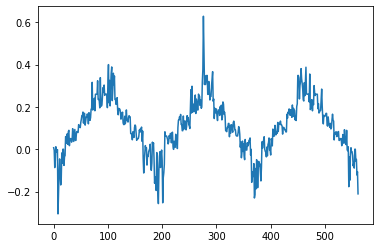

2015-09-28T00:00:00.000000000


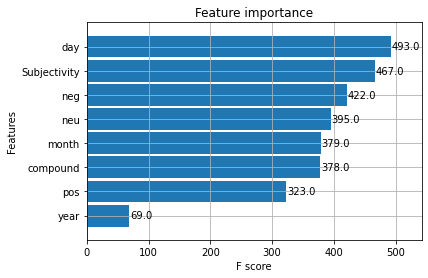

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

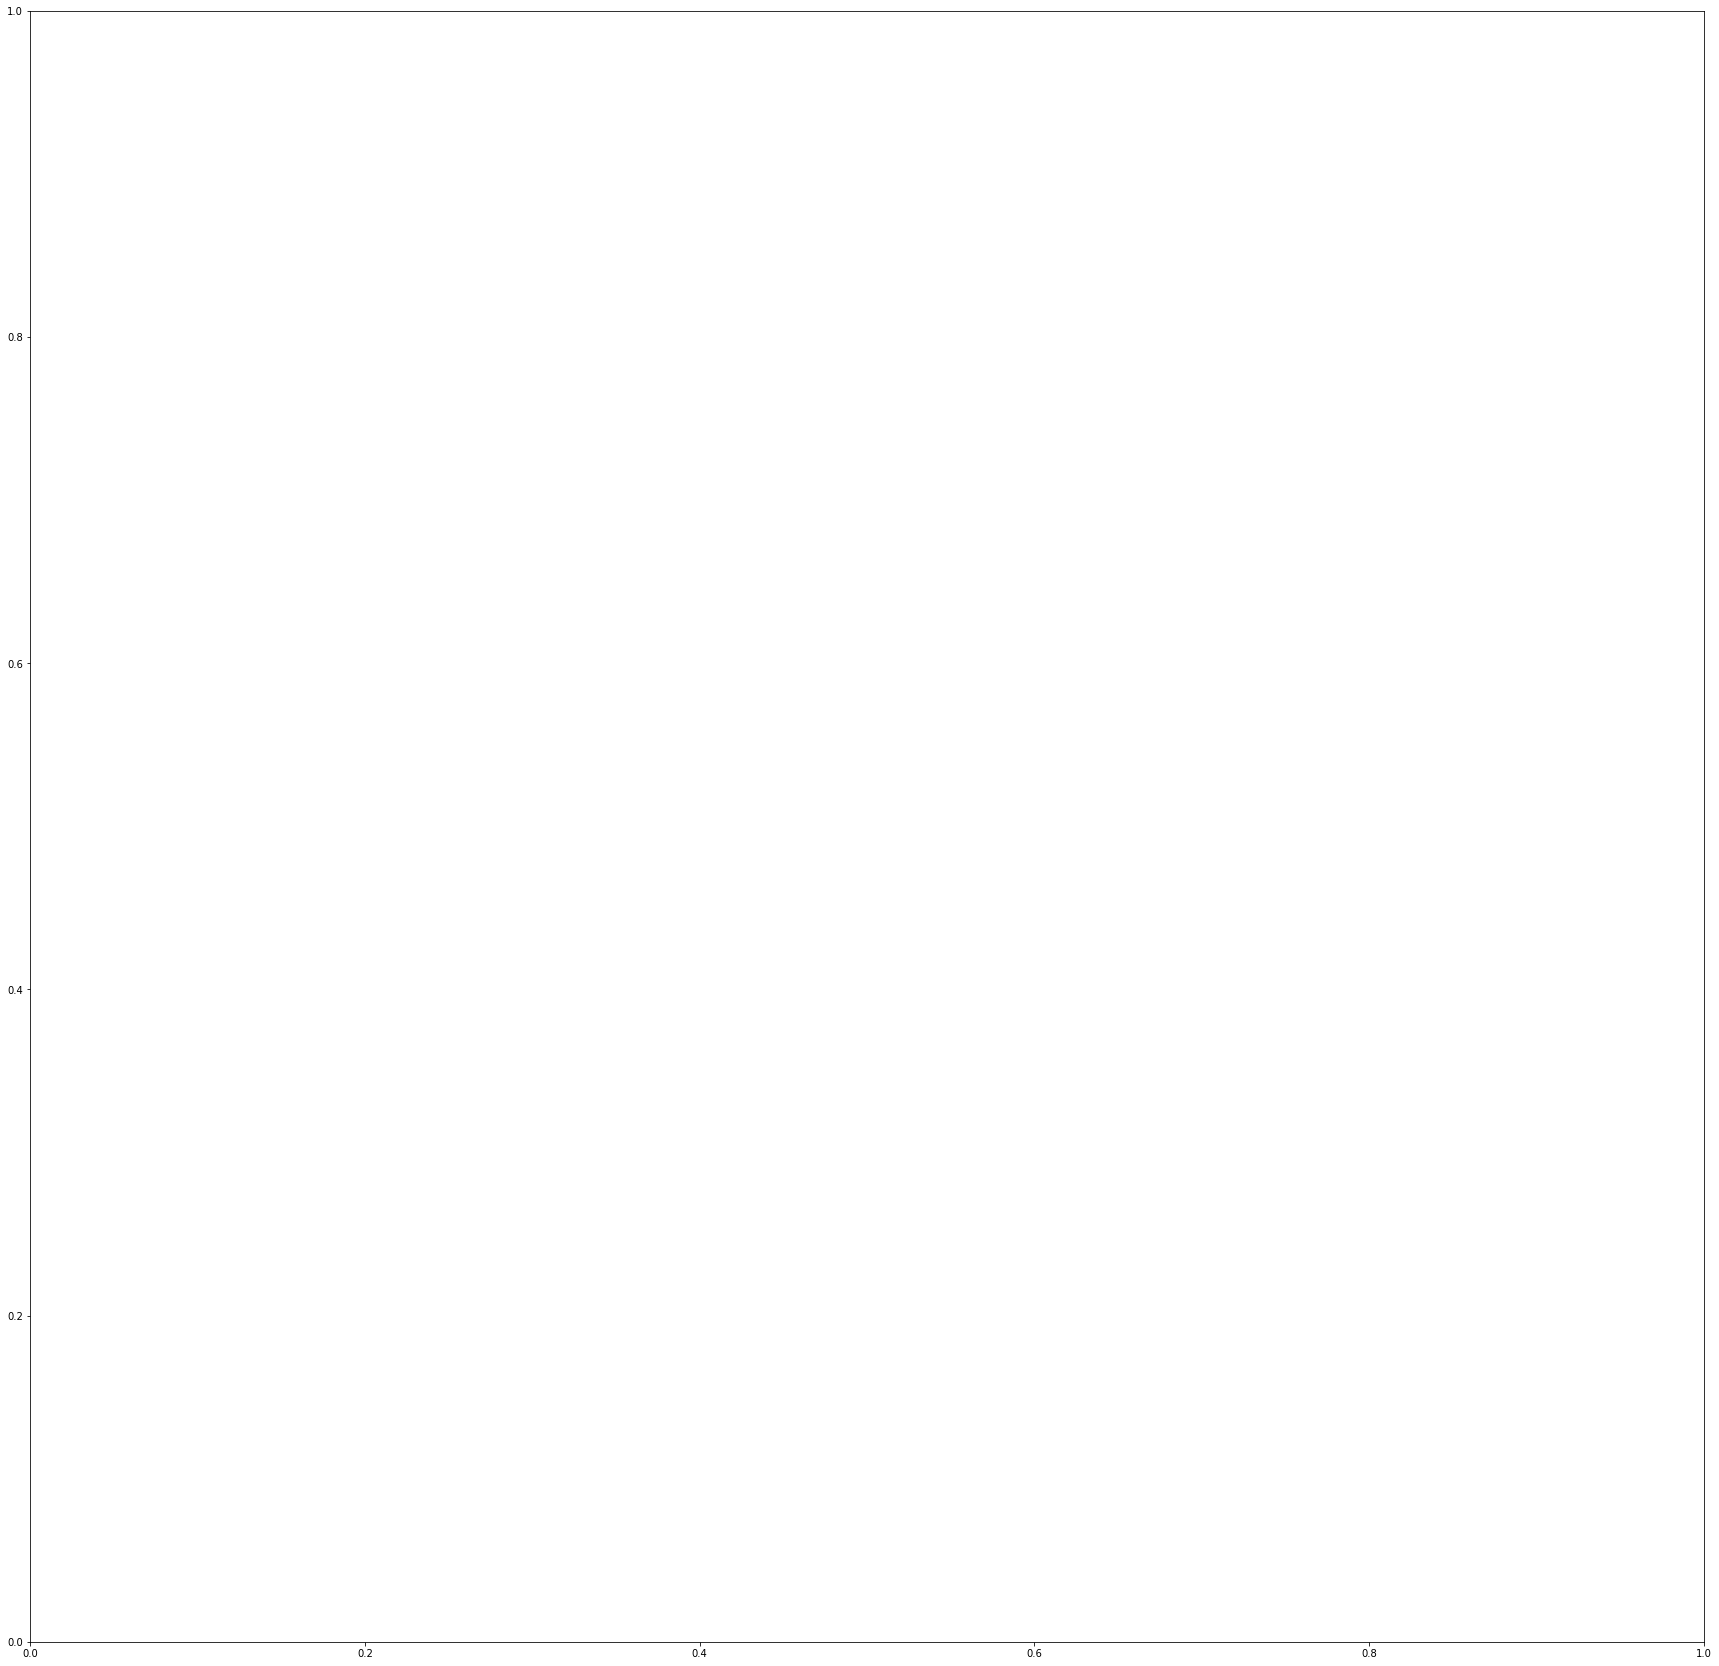

In [15]:
########################################## DATA PREPARATION #############################################################
file_name = "/home/jnieberding/LocalCapstone/env/topic_csv/new_sort.csv"
df = pd.read_csv(file_name, header = 0)

#print(df)
df = df.drop(labels = ['Unnamed: 0'], axis = 1)
df['Sentiment'].plot()

plt.show()

#print(df)

df2 = pd.DataFrame(columns=["year", "month", "day", "date"])
df3 = df["date"].copy()
year = []
day = []
month = []

for i in df3:
    if "/" in i:
        #print(i)
        date_object = datetime.strptime(i, "%m/%d/%Y")
        #print(date_object, type(date_object.month))
        year.append(date_object.year)
        day.append(date_object.day)
        month.append(date_object.month)
    if "-" in i:
        date_object = datetime.strptime(i, "%d-%b-%y")
        #print(date_object, type(date_object.month))
        year.append(date_object.year)
        day.append(date_object.day)
        month.append(date_object.month)


    if "," in i:
        if "Sept." in i:

            date_object = datetime.strptime(i, "%bt. %d, %Y")
            #print(date_object)
            year.append(date_object.year)
            day.append(date_object.day)
            month.append(date_object.month)
        else:
            date_object = datetime.strptime(i, "%b. %d, %Y")
            #print(date_object)
            year.append(date_object.year)
            day.append(date_object.day)
            month.append(date_object.month)

#print(type(year))
df2["year"] = year
df2["day"] = day
df2["month"] = month

test = pd.DataFrame(columns=["year", "month", "day", "date","Sentiment", "Subjectivity", "neg", "neu", "pos","compound", "Topic Prob"])
test[["year", "month", "day"]] = df2[['year','month','day']]
#date["date"] = pd.to_datetime(date[["year", "month", "day"]])
test["date"] = df2[["date"]]
test[["Sentiment", "Subjectivity", "neg", "neu", "pos","compound", "Topic Prob"]] = df[["Sentiment", "Subjectivity", "neg", "neu", "pos","compound", "Topic Prob"]]

#print(type(test))
#print(test)
#print(test[["Sentiment"]].dtypes)
test['Sentiment'] = test['Sentiment'].astype(float)
test['Subjectivity'] = test['Subjectivity'].astype(float)
test['Topic Prob'] = test['Topic Prob'].astype(float)
#print(test)


#indecies = []
index = 0
for i in test["Sentiment"]:
    if i == 0:
        test = test.drop(labels = index, axis = 0)
    #print(index)
    index += 1


test["date"] = pd.to_datetime(df2[["year", "month", "day"]])
test = test.sort_values(by="date")
#print(test)

########################################### Training/Test/Validation Split #############################################

split = 0.85


dates_to_check = test["date"].unique()
split_index = int(dates_to_check.shape[0] * split)

split_date = dates_to_check[split_index]
print(split_date)

training = test.query("date <= @split_date")
valid = test.query("date > @split_date")

#print(test)

#features = ["year", "month", "day", "neg", "neu", "pos", "compound", "Subjectivity", "Topic Prob"]
#features = ["year", "month", "day", "neg", "neu", "pos", "compound", "Topic Prob"]
features = ["year", "month", "day", "neg", "neu", "pos","compound", "Subjectivity"]
#features = ["year", "month", "day", "neg", "neu", "pos","compound"]
#features = ["year", "month", "day"]
#features = ["year", "month", "day", "Subjectivity", "Topic Prob"]

#features = ["year", "month", "day", "topic prob", "subjectivity", "publisher"]
y = ["Sentiment"]
x_train = training[features]
y_train = training[y]
x_valid = valid[features]
y_valid = valid[y]
#print(x_train)
#print(x_valid)


#print(test.isnull().sum())

#train_dmatrix = xgb.DMatrix(data = x_train.values, label = y_train.values)
from sklearn.model_selection import train_test_split

X_train,X_eval,Y_train,Y_eval = train_test_split(x_train, y_train, test_size = 0.15, random_state = 0)



########################## Defining the model based off hyperparameters found in tuning ########################

if file_name == "C:\\Users\\jimni\LocalCapstone\\topic_csv\\2.csv":
    model = xgb.XGBRegressor(n_estimators = 1000,
                            max_depth = 4,
                            min_child_weight = 1.1,
                            learning_rate = 0.235789)
    
elif (file_name == 'C:\\Users\\jimni\LocalCapstone\\topic_csv\\1.csv'):
    model = xgb.XGBRegressor(n_estimators = 300,
                            max_depth = 4,
                            min_child_weight = 1.1,
                            learning_rate = 0.15)
elif file_name == 'C:\\Users\\jimni\LocalCapstone\\topic_csv\\3.csv':
    
    model = xgb.XGBRegressor(n_estimators = 1000,
                             max_depth = 4,
                             min_child_weight = 1.1,
                             learning_rate = 0.235789)


#loaded = pickle.load(open("/home/jnieberding/LocalCapstone/env/xgb_model.pkl", 'rb'))
model.fit(X_train, Y_train,
         eval_set = [(X_eval, Y_eval)],  verbose = 0)    

xgb.plot_importance(model, height = 0.9)
plt.show()

fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(model, num_trees=4, ax=ax)
plt.show()



####################################### Prediction Creation ############################################

pred_eval = X_eval.copy()
pred_valid = x_valid.copy()

#print(pred)
date_stuff = ["year", "month", "day"]

pred_eval["Sentiment prediction"] = model.predict(X_eval)

pred_eval["date"] = pd.to_datetime(pred_eval[date_stuff])
pred_eval = pred_eval.sort_values(by="date")
pred_eval["Sentiment"] = Y_eval
#print(pred_eval)
article_list = []
for i in pred_eval.index:
  article_list.append(df['article'].loc[i])

pred_eval['article'] = article_list
#print(pred_eval)

pred_valid["Sentiment prediction"] = model.predict(x_valid)
pred_valid["Sentiment"] = y_valid


pred_valid["date"] = pd.to_datetime(pred_valid[date_stuff])
pred_valid = pred_valid.sort_values(by="date")

article_list = []
for i in pred_valid.index:
  article_list.append(df['article'].loc[i])

pred_valid['article'] = article_list



#################################### Evaluation Metrics of the Predicted Values ###########################


print("TESTING SCORES")
mae = mean_absolute_error(pred_eval["Sentiment"], pred_eval['Sentiment prediction'])
print('Mean Absolute Error:', mae)

mse = mean_squared_error(pred_eval["Sentiment"], pred_eval['Sentiment prediction'])
print('Mean Squared Error:', mse)
rmse = mean_squared_error(pred_eval["Sentiment"], pred_eval['Sentiment prediction'], squared = False)
print('Root Mean Squared Error:', rmse)

r2 = r2_score(pred_eval["Sentiment"], pred_eval["Sentiment prediction"])
print('R2 Score:', r2)

adjusted_r2 = 1 - (((1-r2)*(pred_valid.shape[0] - 1)) / (pred_valid.shape[0] - x_valid.shape[1] - 1))
print('Adjusted R2 Score:',adjusted_r2)


print("\n\nVALIDATION SCORES")
mae = mean_absolute_error(pred_valid["Sentiment"], pred_valid['Sentiment prediction'])
print('Mean Absolute Error:', mae)

mse = mean_squared_error(pred_valid["Sentiment"], pred_valid['Sentiment prediction'])
print('Mean Squared Error:', mse)
rmse = mean_squared_error(pred_valid["Sentiment"], pred_valid['Sentiment prediction'], squared = False)
print('Root Mean Squared Error:', rmse)

r2 = r2_score(pred_valid["Sentiment"], pred_valid["Sentiment prediction"])
print('R2 Score:', r2)

#print(pred_valid.shape[0], x_valid.shape[1])
adjusted_r2 = 1 - (((1-r2)*(pred_valid.shape[0] - 1)) / (pred_valid.shape[0] - x_valid.shape[1] - 1))
print('Adjusted R2 Score:',adjusted_r2,'\n\n')



############################## Plotting the results of the Testing Set using during training #############################

print("Feature Vector with all Features\n\nPrediction of the Testing Set")
pred_vis = pred_eval.melt(id_vars = ["date"], value_vars = ["Sentiment prediction", "Sentiment"],var_name = "type", value_name = "sent")

fig = px.line(pred_vis, x = "date", y = "sent", color = "type", )
fig.show()


#################################### Gathering the articles that are associated with peaks and valleys ##################

'''testing = pred_eval.copy()
#print(testing)
##print(testing)
testing = testing.reset_index()



ind = testing['Sentiment'].idxmax(axis = 0)


print("The max predicted sentiment was on", testing['date'].loc[ind])
for i in range(ind-1, ind + 2):
  print('\n\nDate:',testing['date'].loc[i])
  print("The actual sentiment was", testing["Sentiment"].loc[i])
  print("The predicted sentiment is", testing['Sentiment prediction'].loc[i])
  print("Article:\n", testing['article'].loc[i])
    



ind = testing['Sentiment'].idxmin(axis = 0)


print("\n#######################################\nThe min predicted sentiment was on", testing['date'].loc[ind])
for i in range(ind-1, ind + 2):
  print('\n\nDate:',testing['date'].loc[i])
  print("The actual sentiment was", testing["Sentiment"].loc[i])
  print("The predicted sentiment is", testing['Sentiment prediction'].loc[i])
  print("Article:\n", testing['article'].loc[i])'''
    
    
################################### Plotting the prediction results of the validation set #################################
    
print("Feature Vector with all Features\n\nPrediction of the Validation Set")
pred_vis = pred_valid.melt(id_vars = ["date"], value_vars = ["Sentiment prediction", "Sentiment"],var_name = "type", value_name = "sent")

fig = px.line(pred_vis, x = "date", y = "sent", color = "type", )
fig.show()    
 
    
    
    


**Narrative Curve With Loaded Trained Model**